<!-- Copyright (c) 2021-2022, InterDigital Communications, Inc
All rights reserved.

Redistribution and use in source and binary forms, with or without 
modification, are permitted (subject to the limitations in the disclaimer 
below) provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, 
this list of conditions and the following disclaimer.
* Redistributions in binary form must reproduce the above copyright notice, 
this list of conditions and the following disclaimer in the documentation 
and/or other materials provided with the distribution.
* Neither the name of InterDigital Communications, Inc nor the names of its 
contributors may be used to endorse or promote products derived from this 
software without specific prior written permission.

NO EXPRESS OR IMPLIED LICENSES TO ANY PARTY'S PATENT RIGHTS ARE GRANTED BY 
THIS LICENSE. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND 
CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT 
NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A 
PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER 
OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, 
EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, 
PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; 
OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, 
WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR 
OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF 
ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. -->

# CompressAI inference demo

In [1]:
import math
import io
import torch
from torchvision import transforms
import numpy as np
import pickle
import re
import scipy.stats as st

from PIL import Image

import matplotlib.pyplot as plt

In [2]:
from pytorch_msssim import ms_ssim

In [3]:
from compressai.zoo import bmshj2018_factorized

/Users/sophiestrebel/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [4]:
from compressai.dna_entropy_coding.coder import Coder

In [5]:
from ipywidgets import interact, widgets

## Global settings

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load a pretrained model

In [7]:
quality_level = 1
net = bmshj2018_factorized(quality = quality_level, pretrained=True).eval().to(device)

In [8]:
print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

Parameters: 2998147


## Functions to run the modified autoencoder

In [9]:
def compute_x_hat(x, quality=1, include_rounded=False):
    """
    Runs the given image tensor for a given quality level through the forward part of the CompressAI autoencoder, 
    encodes the non trivial channels of the quantized latent space into DNA, decodes the DNA strand and runs the
    latent space representation though the inverse transformations of the CompressAI autoencoder. Results in the 
    reconstructed image tensor. This is the modified autoencoder.

    Parameters
    ----------
    x : tensor
        image tensor to run through the modified autoencoder
    quality : int, optional
        quality level at which to encode the image
        

    Returns
    -------
    The reconstructed image tensor and length of the encoded DNA strand
    """
    net = bmshj2018_factorized(quality = quality, pretrained=True).eval().to(device)

    with torch.no_grad():
        dictionary = net.get_y_hat_and_medians(x)
        y_hat = dictionary['y_hat']
        medians = dictionary['medians']

    coder = Coder()
    rounded = y_hat-torch.unsqueeze(medians, dim=0)
    rounded = torch.round(rounded).int()

    dna = coder.encode(rounded, quality)                               
    rounded_decoded = coder.decode(dna, quality, x.shape)

    y_hat_decoded = rounded_decoded + torch.unsqueeze(medians, dim=0)

    with torch.no_grad():
        dict_dna = net.get_x_hat(y_hat_decoded)
        out_net_dna = {'x_hat': dict_dna['x_hat']}
        out_net_dna['x_hat'] = out_net_dna['x_hat'].clamp(0, 1)
    
    if include_rounded:
        return out_net_dna['x_hat'], len(dna), rounded
    return out_net_dna['x_hat'], len(dna)

In [10]:
def plot_channels(rounded):
    """
    Takes the rounded tensor that we want to encode into DNA and, for each channel (192 for quality levels 1-5 and
    320 otherwise), plot the values contained in that channel on a logarithmic scale.

    Parameters
    ----------
    rounded : tensor
        quantized latent space representation of the original image vector
    """
    rounded = torch.clone(rounded) #we modify the given tensor
    n = rounded.shape[1]
    for i in range(n): #shape of y is 1, n, image_y/16, image_x/16. Here: range(n)
        rounded_i = rounded[0][i]
        
        flattened = torch.flatten(rounded_i)
        elements, counts = torch.unique(flattened, return_counts=True)
        plt.semilogy(elements, counts, '.')

In [11]:
def get_non_trivial_channels(rounded):
    """
    Takes the rounded tensor that we want to encode into DNA and, for each channel (192 for quality levels 1-5 and
    320 otherwise), checks whether the channel only contains 0s or whether it contains non trivial elements. Only
    channels containing non trivial elements are relevant to encode into DNA. Returns a list of those non trivial
    channels.

    Parameters
    ----------
    rounded : tensor
        quantized latent space representation of the original image vector

    Returns
    -------
    The indices of the channels that do not only contain 0.
    """
    rounded = torch.clone(rounded) #we modify the given tensor
    
    n = rounded.shape[1]
    non_trivial_channels = list()
    for i in range(n): #shape of y is 1, n, image_y/16, image_x/16. Here: range(n)
        rounded_i = rounded[0][i]
        
        flattened = torch.flatten(rounded_i)
        elements = torch.unique(flattened)
        if len(elements) != 1: #if there was only one element, 0, no need to encode whole channel
            non_trivial_channels.append(i)
        else:
            if 0 not in elements:
                non_trivial_channels.append(i)
            
    return non_trivial_channels


In [12]:
def get_image(image_location='./assets/kodim01.png'):
    """
    Gets and returns the image tensor at the given location and the number of pixels of the image

    Parameters
    ----------
    image_location : string
        location of the image to get. By default, the location of the first image of the kodak dataset

    Returns
    -------
    The image tensor at the given location and the number of pixels of the image
    """

    img = Image.open(image_location).convert('RGB')
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    return x, np.prod(img.size)

## 1. Inference

### Load image and convert to 4D float tensor

First, we need to load an RGB image and convert it to a 4D floating point tensor, as the network expectes an input tensor of size: `(batch_size, 3, height, width)`.

In [13]:
img = Image.open('./assets/kodim01.png').convert('RGB')
x = transforms.ToTensor()(img).unsqueeze(0).to(device)

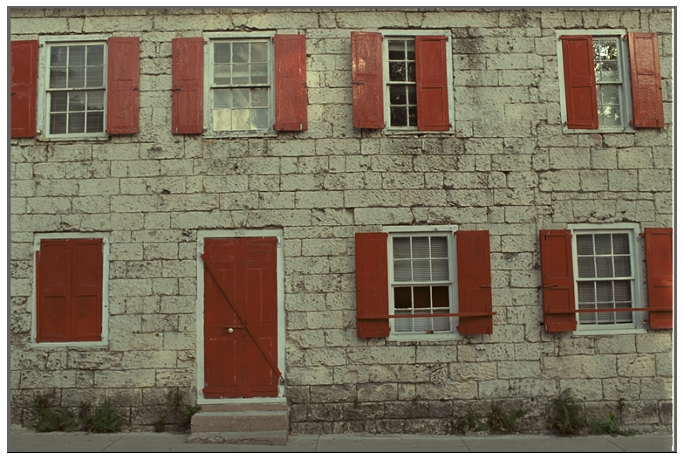

In [14]:
%matplotlib inline
plt.figure(figsize=(12, 9))
plt.axis('off')
plt.imshow(img)
plt.show()

### Run the network

The following code runs the previously extracted image through the normal network (CompressAI without DNA addition) and through the modified autoencoder and compares the resulting $\hat{x}$. They should always be equal.

In [15]:
with torch.no_grad():
    forward_dictionary = net.forward(x)
    out_net = {k: forward_dictionary[k] for k in ('x_hat', 'likelihoods')}
    out_net['x_hat'] = out_net['x_hat'].clamp(0, 1)

x_hat, L, rounded = compute_x_hat(x, quality_level, include_rounded=True)
out_net_dna = {'x_hat': x_hat}
print(f"CompressAI x_hat without DNA == CompressAI x_hat with DNA: {torch.equal(out_net['x_hat'], x_hat)}")

/Users/sophiestrebel/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/sophiestrebel/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/sophiestrebel/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/sophiestrebel/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not availabl

CompressAI x_hat without DNA == CompressAI x_hat with DNA: True


`plot_channels` can be called with the quantized tensor (`rounded` in `compute_x_hat`) in order to plot the channels.

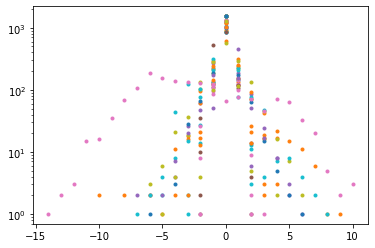

In [16]:
plot_channels(rounded)

### Visualize result

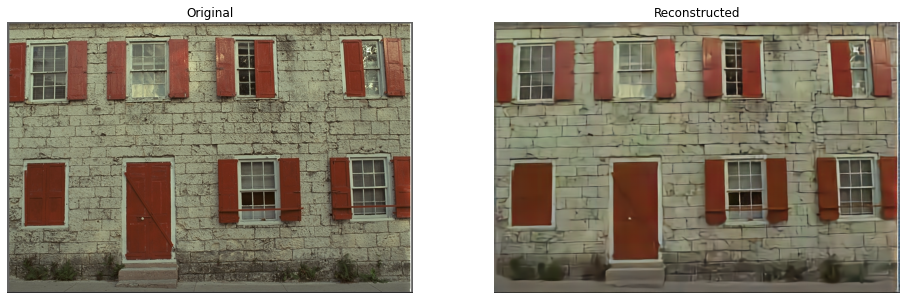

In [17]:
rec_net = transforms.ToPILImage()(out_net['x_hat'].squeeze().cpu())

%matplotlib inline
fix, axes = plt.subplots(1, 2, figsize=(16, 12))
for ax in axes:
    ax.axis('off')
    
axes[0].imshow(img)
axes[0].title.set_text('Original')

axes[1].imshow(rec_net)
axes[1].title.set_text('Reconstructed')

plt.show()

Since the sizes differ (for some images), the following code takes only the portion similar to the original image in order to be able to compare the two:

In [18]:
height = x.shape[2]
width = x.shape[3]
out_net_dna['x_hat'] = out_net_dna['x_hat'][:, :, :height, :width]
out_net['x_hat'] = out_net['x_hat'][:, :, :height, :width]

Convert the Tensor back to a 2D Pillow image:

In [19]:
rec_net = transforms.ToPILImage()(out_net['x_hat'].squeeze().cpu())

In [20]:
height = x.shape[2]
width = x.shape[3]
diff = torch.mean((out_net_dna['x_hat'][:, :, :height, :width] - x).abs(), axis=1).squeeze().cpu()

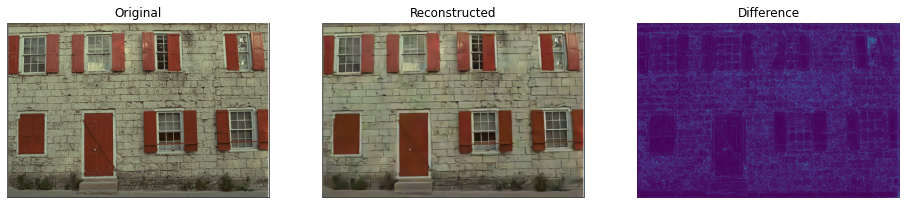

In [21]:
%matplotlib inline
fix, axes = plt.subplots(1, 3, figsize=(16, 12))
for ax in axes:
    ax.axis('off')
    
axes[0].imshow(img)
axes[0].title.set_text('Original')

axes[1].imshow(rec_net)
axes[1].title.set_text('Reconstructed')

axes[2].imshow(diff, cmap='viridis')
axes[2].title.set_text('Difference')

plt.show()

### Compute metrics

Now, let's compute some common metrics...

In [22]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

In [23]:
print(f'PSNR: {compute_psnr(x, out_net_dna["x_hat"]):.2f}dB')
print(f'MS-SSIM: {compute_msssim(x, out_net_dna["x_hat"]):.4f}')
print(f'Bit-rate: {compute_bpp(out_net):.3f} bpp')

PSNR: 24.74dB
MS-SSIM: 0.8984
Bit-rate: 0.164 bpp


# Functions

Note that the JPEG AIC dataset is, in this Jupyter notebook, still referred to as DNA dataset, in order to avoid changing the names of all variables, files and images already generated and saved.

## Functions for the modified autoencoder

These functions were used to run all kodak images and dna dataset images through the modified autoencoder with all quality levels and get the results. This takes quite some time, which is why the actual results are stored in pickle files to avoid rerunning every time, but the utilitary functions are left for completeness.

In [24]:
def get_dna_compressai_x_hats(image_location='./assets/kodim01.png'):
    """
    Runs the image at the given location through the modified autoencoder for each of the 8 quality levels 
    and retuns a list of tuples containing the original image tensor, the reconstructed image tensor, 
    the length of the encoded DNA strand and the number of pixels of the original image (later on used to 
    calculate the rate)

    Parameters
    ----------
    image_location : string
        location of the image to encode. By default, the location of the first image of the kodak dataset

    Returns
    -------
    A list containing the original image tensor, the reconstructed image tensor, the length of the encoded DNA strand
    and the number of pixels of the image for each quality level
    """

    x, number_of_pixels = get_image(image_location=image_location)

    info_list = list()

    for q in range(1, 9):
        x_hat, dna_length = compute_x_hat(x, quality = q)
        info_list.append((x, x_hat, dna_length, number_of_pixels))
    
    return info_list

In [25]:
def get_plot_values_compressai_dna(info):
    """
    Calculates and returns the values to be plotted (MS-SSIM, PSNR and the rates) from the reconstructed 
    image vectors and their DNA strand lengths, the original image and its size

    Parameters
    ----------
    info : list
        A list containing the original image vector, the reconstructed image vector,
        the length of the encoded DNA strand and the number of pixels in the image
        for each quality level

    Returns
    -------
    The rates, MS-SSIM and PSNR values and reconstructed image vectors for each quality levels
    """
    
    rate = [dna_length/nb_pixels for (x, x_hat, dna_length, nb_pixels) in info]
    original_x, ignored_xhat, ignored_length, ignored_pixels = info[0]
    
    height = original_x.shape[2]
    width = original_x.shape[3]
    
    msssim_values = [compute_msssim(x, x_hat[:, :, :height, :width]) for (x, x_hat, dna_length, nb_pixels) in info]
    psnr_values = [compute_psnr(x, x_hat[:, :, :height, :width]) for (x, x_hat, dna_length, nb_pixels) in info]

    x_hats = [x_hat for (x, x_hat, dna_length, nb_pixels) in info]
    return rate, msssim_values, psnr_values, x_hats

## Functions for JPEG DNA BC

These functions are used to extract the reconstructed images at the given alpha values, which were previously encoded and decoded separately in the JPEG DNA BC.

In [26]:
alphas = [0.2, 0.37, 0.5, 0.75, 1., 1.5, 2., 3.]

In [27]:
def get_jpeg_images(image_name):
    """
    Gets the images reconstructed using the JPEG DNA BC for all qualities of the image corresponding to the
    given name, extracts their tensor representation and returns a list of them

    Parameters
    ----------
    image_name : string
        the name of the image of which the decoded version for 8 quality levels will be fetched

    Returns
    -------
    A list of the reconstructed images of "image_name"
    """
    
    jpeg_x_hats = list()
    for i in range(1, 9):
        x, ignored = get_image(f"./assets/{image_name}_decoded{i}.png")
        jpeg_x_hats.append(x)

    return jpeg_x_hats

In [28]:
def get_values_from_file_jpeg(filename=f"./assets/alphaDNALengthPixelLog01.txt"):
    """
    Gets the alpha values, DNA strand lengths and number of pixels of the original image from the given file 
    location, and returns a dictionary containing a tuple of DNA length and number of pixels for each alpha value

    Parameters
    ----------
    filename : string
        the name of the file containing the alpha values, length of DNA strand and number of pixels of image

    Returns
    -------
    a dictionary mapping alpha values to the length of the DNA strand of the image encoded with this alpha value
    and the size of the original image (the same for all alpha values)
    """
        
    dictionary = dict()
    
    with open(filename, "r") as f:
        for i in range(8):
            line = f.readline()
            values = re.findall(r"[-+]?(?:\d*\.\d+|\d+)", line)
            assert len(values) == 3
            dictionary[float(values[0])] = (int(values[1]), int(values[2]))

    return dictionary

In [29]:
def get_plot_values_jpeg(jpeg_x_hats, alpha_values, file_name, img_nb, img_type="kodim"):
    """
    Calculates and returns the values to be plotted (MS-SSIM, PSNR and the rates) from the provided JPEG
    reconstructed images and their corresponding alpha values, the file location in which the DNA length 
    (and alpha values) is stored and the type (dataset) and number of the image

    Parameters
    ----------
    jpeg_x_hats : list of tensors
        list of reconstructed images using JPEG DNA BC (corresponding to the alpha values)
    alpha_values : list
        list of values used to encode the image with JPEG DNA BC
    file_name : string
        location of the file containing the alpha values, length of DNA strand and number of pixels of the original
        image, for each reconstructed image
    img_nb : int
        the number of the image (1-10 for the DNA dataset, 1-24 for the kodak dataset)
    img_type : string
        "kodim" or "dna_im_" depending on the dataset
        
    Returns
    -------
    The rates, MS-SSIM and PSNR values, and reconstructed image vectors for each alpha value (in order
    of increasing quality)
    """
    assert len(alpha_values) == len(jpeg_x_hats)
    zipped = [(alpha_values[i], jpeg_x_hats[i]) for i in range(len(alpha_values))]

    rate_dictionary = get_values_from_file_jpeg(file_name)
    
    rate_dictionary = {alpha: dna_len/pixels for alpha, (dna_len, pixels) in rate_dictionary.items()}
    jpeg_rates_xhat = [(rate_dictionary[alpha_i], x_hat_i) for (alpha_i, x_hat_i) in zipped]
    jpeg_rates_xhat = sorted(jpeg_rates_xhat)

    original_x, number_of_pixels = get_image(image_location=f"./assets/{img_type}{img_nb:02d}.png")

    jpeg_msssim = [compute_msssim(original_x, x_hat) for (rate_val, x_hat) in jpeg_rates_xhat]
    jpeg_psnr = [compute_psnr(original_x, x_hat) for (rate_val, x_hat) in jpeg_rates_xhat]
    rate_x_axis = [rate_val for (rate_val, x_hat) in jpeg_rates_xhat]
    
    x_hats_in_order = [x_hat for (rate_val, x_hat) in jpeg_rates_xhat]
    return rate_x_axis, jpeg_msssim, jpeg_psnr, x_hats_in_order

## Functions to plot the results for one image

`plot_jpeg_dnaCompressAI` is also used later to plot the average of all images with a confidence interval.

In [30]:
def plot_jpeg_dnaCompressAI(dna_info, jpeg_info, image_name, ci=None):
    """
    Plots the MS-SSIM and PSNR metrics for both the JPEG and modified CompressAI methods, as well as the
    confidence intervals if provided with one

    Parameters
    ----------
    dna_info : tuple of lists
        contains the rates, MS-SSIM values and PSNR values for all quality levels of the modified autoencoder
    jpeg_info : tuple of lists
        contains the rates, MS-SSIM values and PSNR values for all alpha values of the JPEG DNA BC
    image_name : string
        the name of the image, title for the plot
    ci : tuple or arrays, optional
        if None, no confidence intervals are drawn
        otherwise, ci contains the 95% confidence intervals for MS-SSIM and PSNR values for both JPEG and CompressAI
        (modified) methods
    """
    if ci != None:
        (ci_jpeg_msssim, ci_comp_msssim, ci_jpeg_psnr, ci_comp_psnr) = ci
    rate_jpeg, msssim_jpeg, psnr_jpeg = jpeg_info
    rate_dna, msssim_dna, psnr_dna = dna_info
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    axes[0].plot(rate_dna, msssim_dna, label="CompressAI-DNA", linestyle='-', marker='.', color='blue')
    if ci != None:
        axes[0].fill_between(rate_dna, ci_comp_msssim[:, 0], ci_comp_msssim[:, 1], color='blue', alpha=0.1)

    axes[0].plot(rate_jpeg, msssim_jpeg, label="JPEG", linestyle='-', marker='.', color='orange')
    if ci != None:
        axes[0].fill_between(rate_jpeg, ci_jpeg_msssim[:, 0], ci_jpeg_msssim[:, 1], color='orange', alpha=0.1)
    
    axes[0].title.set_text(f'MS-SSIM - {image_name}')
    axes[0].set_xlabel('Rate (nts/pixels)')
    axes[0].set_ylabel('MS-SSIM')
    axes[0].legend(loc='lower right')

    
    axes[1].plot(rate_dna, psnr_dna, label = "CompressAI-DNA", linestyle='-', marker='.', color='blue')
    if ci != None:
        axes[1].fill_between(rate_dna, ci_comp_psnr[:, 0], ci_comp_psnr[:, 1], color='blue', alpha=0.1)
    
    axes[1].plot(rate_jpeg, psnr_jpeg, label="JPEG", linestyle='-', marker='.', color='orange')
    if ci != None:    
        axes[1].fill_between(rate_jpeg, ci_jpeg_psnr[:, 0], ci_jpeg_psnr[:, 1], color='orange', alpha=0.1)
    
    axes[1].title.set_text(f'PSNR - {image_name}')
    axes[1].set_xlabel('Rate (nts/pixels)')
    axes[1].set_ylabel('PSNR')
    axes[1].legend(loc='lower right')

    fig.tight_layout()

In [31]:
def calculate_and_plot_image(img_nb, img_type):
    """
    Calculates, plots and returns the MS-SSIM and PSNR values, rates and reconstructed image vectors
    for all quality levels and alpha values for the modified CompressAI and JPEG DNA BC respectively

    Parameters
    ----------
    img_nb : int
        the number of the image (1-10 for the DNA dataset, 1-24 for the kodak dataset)
    img_type : string
        "kodim" or "dna_im_" depending on the dataset
        
    Returns
    -------
    The rates, MS-SSIM and PSNR values, and reconstructed image vectors for each alpha value (in order
    of increasing quality)
    """
    information = get_dna_compressai_x_hats(image_location=f'./assets/{img_type}{img_nb:02d}.png')
    rate_dna, msssim_dna, psnr_dna, compressai_x_hats = get_plot_values_compressai_dna(information)
    
    jpeg_x_hats = get_jpeg_images(f"{img_type}{img_nb:02d}")
    log_file_name = (f"./assets/alphaDNALengthPixelLogKodim{img_nb:02d}.txt" if img_type=="kodim" 
                     else f"./assets/alphaDNALengthPixelLogDNAim{img_nb:02d}.txt")
    rate_jpeg, msssim_jpeg, psnr_jpeg, jpeg_x_hats = get_plot_values_jpeg(jpeg_x_hats, alphas, log_file_name, 
                                                                          img_nb, img_type)
    
    plot_title = "kodim" if img_type=="kodim" else "DNA image"
    plot_jpeg_dnaCompressAI((rate_dna, msssim_dna, psnr_dna), (rate_jpeg, msssim_jpeg, psnr_jpeg), 
                            f"{plot_title} {img_nb:02d}")
    
    jpeg_info = (jpeg_x_hats, rate_jpeg, msssim_jpeg, psnr_jpeg)
    compressai_info = (compressai_x_hats, rate_dna, msssim_dna, psnr_dna)
    return jpeg_info, compressai_info

## Functions to run code for all images & quality levels

In [32]:
def calculate_reconstructed_image(img_nb, img_type):
    """
    Calculates and returns the MS-SSIM and PSNR values, rates and reconstructed image vectors
    for all quality levels and alpha values for the modified CompressAI and JPEG DNA BC respectively

    Parameters
    ----------
    img_nb : int
        the number of the image (1-10 for the DNA dataset, 1-24 for the kodak dataset)
    img_type : string
        "kodim" or "dna_im_" depending on the dataset
        
    Returns
    -------
    The rates, MS-SSIM and PSNR values, and reconstructed image vectors for each alpha value (in order
    of increasing quality)
    """
    information = get_dna_compressai_x_hats(image_location=f'./assets/{img_type}{img_nb:02d}.png')
    rate_dna, msssim_dna, psnr_dna, compressai_x_hats = get_plot_values_compressai_dna(information)
    
    jpeg_x_hats = get_jpeg_images(f"{img_type}{img_nb:02d}")
    log_file_name = (f"./assets/alphaDNALengthPixelLogKodim{img_nb:02d}.txt" if img_type=="kodim" 
                     else f"./assets/alphaDNALengthPixelLogDNAim{img_nb:02d}.txt")
    rate_jpeg, msssim_jpeg, psnr_jpeg, jpeg_x_hats = get_plot_values_jpeg(jpeg_x_hats, alphas, log_file_name, 
                                                                          img_nb, img_type)
    jpeg_info = (jpeg_x_hats, rate_jpeg, msssim_jpeg, psnr_jpeg)
    compressai_info = (compressai_x_hats, rate_dna, msssim_dna, psnr_dna)
    return jpeg_info, compressai_info

In [33]:
def add_to_lists(jpeg_info, compressai_info, lists_jpeg, lists_compressai):
    """
    Adds the given information (rates, MS-SSIM and PSNR values and reconstructed image tensor) of both
    JPEG DNA BC and the modified autoencoder to the corresponding lists (modifying them directly), 
    also provided as parameters

    Parameters
    ----------
    compressai_info : tuple of lists
        contains the rates, MS-SSIM and PSNR values for all quality levels of the modified autoencoder
    jpeg_info : tuple of lists
        contains the rates, MS-SSIM values and PSNR values for all alpha values of the JPEG DNA BC
    lists_jpeg : list
        list of tuples (containing rates, MS-SSIM and PSNR values, and reconstructed image tensor for one
        image, for each alpha value) for the JPEG DNA BC
    lists_compressai : list
        list of tuples (containing rates, MS-SSIM and PSNR values, and reconstructed image tensor for one
        image, for each quality level) for the modified autoencoder adapted from CompressAI
    """
    jpeg_rates, jpeg_mssim, jpeg_psnr, jpeg_xhats = lists_jpeg
    compressai_rates, compressai_mssim, compressai_psnr, compressai_xhats = lists_compressai
    
    jpeg_x_hat, rate_jpeg, msssim_jpeg, psnr_jpeg = jpeg_info
    compressai_x_hat, rate_compressai, msssim_compressai, psnr_compressai = compressai_info
    
    jpeg_rates.append(rate_jpeg)
    jpeg_mssim.append(msssim_jpeg)
    jpeg_psnr.append(psnr_jpeg)
    jpeg_xhats.append(jpeg_x_hat)
    
    compressai_rates.append(rate_compressai)
    compressai_mssim.append(msssim_compressai)
    compressai_psnr.append(psnr_compressai)
    compressai_xhats.append(compressai_x_hat)

In [34]:
def get_rates_xhats_quality_levels(img_type):
    """
    For each image in the dataset (whose name is provided), calculated the reconstructed image and stores the
    information (rates, MS-SSIM and PSNR values, and reconstructed image) in a list for both the JPEG DNA BC
    and the modified autoencoder
    
    Parameters
    ----------
    img_type : string
        "kodim" or "dna_im_" depending on the dataset
        
    Returns
    -------
    The rates, MS-SSIM and PSNR values, and reconstructed image vectors for each alpha value and quality level
    respectively for the modified autoencoder and the JPEG DNA BC, for each image of the dataset.
    """
    nb_images = 24 if img_type == "kodim" else 10
    
    jpeg_rates = list()
    jpeg_mssim = list()
    jpeg_psnr  = list()
    jpeg_xhats = list()

    compressai_rates  = list()
    compressai_mssim  = list()
    compressai_psnr   = list()
    compressai_xhats  = list()
    
    for i in range(1, nb_images+1):
        jpeg_info, compressai_info = calculate_reconstructed_image(img_nb=i, img_type=img_type)
        add_to_lists(jpeg_info, compressai_info, (jpeg_rates, jpeg_mssim, jpeg_psnr, jpeg_xhats), 
                     (compressai_rates, compressai_mssim, compressai_psnr, compressai_xhats))
        
    jpeg_lists = (jpeg_rates, jpeg_mssim, jpeg_psnr, jpeg_xhats)
    compressai_lists = (compressai_rates, compressai_mssim, compressai_psnr, compressai_xhats)
    return jpeg_lists, compressai_lists

## Functions to calculate the average & confidence intervals of quality metrics

In [35]:
def get_average(list_of_values):
    """
    Computes and returns the average along all images of a dataset
    
    Parameters
    ----------
    list_of_values : list
        list of size n, where n is the size of the dataset. Each element of the list contains some information 
        (rate or quality metrics) for each quality level/alpha value for all images of a dataset (so another list
        of size 8).
        
    Returns
    -------
    The computed average.
    """
    np_list = np.array([np.array(value) for value in list_of_values])
    return np.average(np_list, axis = 0)
    

def get_averages(jpeg_rates, compressai_rates, jpeg_mssim, compressai_mssim, jpeg_psnr, compressai_psnr):
    """
    Computes and returns the average along all images of a dataset for each of the provided information lists
    (rates, MS-SSIM and PSNR values for both the JPEG DNA BC and the modified CompressAI autoencoder)
    
    Parameters
    ----------
    jpeg_rates : list
        contains the rates for all images and alpha values of the images encoded with the JPEG DNA BC
    compressai_rates : list
        contains the rates for all images and quality levels of the images encoded with the modified 
        CompressAI autoencoder
    jpeg_mssim : list
        contains the MS-SSIM values for all images and alpha values of the images encoded with the JPEG DNA BC
    compressai_mssim : list
        contains the MS-SSIM values for all images and quality levels of the images encoded with the 
        modified CompressAI autoencoder
    jpeg_psnr : list
        contains the PSNR values for all images and alpha values of the images encoded with the JPEG DNA BC
    compressai_psnr : list
        contains the PSNR values for all images and quality levels of the images encoded with the 
        modified CompressAI autoencoder      
        
    Returns
    -------
    The computed averages for each list.
    """
    average_jpeg_rate = get_average(jpeg_rates)
    average_compressai_rate = get_average(compressai_rates)

    average_jpeg_msssim = get_average(jpeg_mssim)
    average_compressai_msssim = get_average(compressai_mssim)

    average_jpeg_psnr = get_average(jpeg_psnr)
    average_compressai_psnr = get_average(compressai_psnr)
    
    return (average_jpeg_rate, average_compressai_rate, average_jpeg_msssim, 
            average_compressai_msssim, average_jpeg_psnr, average_compressai_psnr)

In [36]:
def get_ci(array):
    """
    Computes and returns the 95% confidence intervals of the quality metrics (PSNR and MS-SSIM) for
    all quality levels/alpha values of all images of a dataset
    
    Parameters
    ----------
    array : list
        contains the quality metric (MS-SSIM or PSNR) for each alpha value/quality level for all images of a datset
        
    Returns
    -------
    The upper and lower bound (2) of the confidence interval for each of the quality levels/alpha values (8) in the
    form of an 8x2 array
    """
    array = np.array([np.array(quality_score) for quality_score in array])
    array_to_fill=np.zeros((8, 2))
    for i in range(8):
        a = array[:, i]
        (m, M) = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
        array_to_fill[i, 0] = m
        array_to_fill[i, 1] = M
    return array_to_fill

def get_all_ci_s(jpeg_mssim, compressai_mssim, jpeg_psnr, compressai_psnr):
    """
    Computes and returns the 95% confidence intervals of the PSNR and MS-SSIM values for both the JPEG DNA BC and 
    the modified CompressAI autoencoder
    
    Parameters
    ----------
    jpeg_mssim : list
        contains the MS-SSIM values for all images and alpha values of the images encoded with the JPEG DNA BC
    compressai_mssim : list
        contains the MS-SSIM values for all images and quality levels of the images encoded with the 
        modified CompressAI autoencoder
    jpeg_psnr : list
        contains the PSNR values for all images and alpha values of the images encoded with the JPEG DNA BC
    compressai_psnr : list
        contains the PSNR values for all images and quality levels of the images encoded with the 
        modified CompressAI autoencoder      
            
    Returns
    -------
    The computed confidence interval of the PSNR and MS-SSIM values for the JPEG DNA BC and the modified autoencoder
    """
    return (get_ci(jpeg_mssim), get_ci(compressai_mssim), get_ci(jpeg_psnr), get_ci(compressai_psnr))

## Functions to extract data from pickle files

As mentioned above, the running of all images at all quality levels takes a long time and the rsults were therefore previously stored in pickle files (which are not on git and in this project due to the size of the pickle files). These functions extract the pickle variable to avoid rerunning everything.

In [37]:
def get_pickle_variable(filename):
    """
    Opens the file, loads and returns the pickle variable contained in the file
    
    Parameters
    ----------
    filename : string
        name of the pickle file
        
    Returns
    -------
    The pickle variable stored in the file
    """
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [38]:
def get_xhats_from_pickle_file(method):
    """
    Gets the reconstructed image tensors from the pickle files. Note that This method exists because the 
    reconstructed image tensors are very big and therefore stored in different pickle files.
    
    Parameters
    ----------
    method : string
        "jpeg" of "compressai" depending on the method used
        
    Returns
    -------
    A list of all reconstructed image tensors, "x_hat"
    """
    sublist1 = get_pickle_variable(f'saved_dna_dataset_{method}_xhats_1_to_5.pkl')
    sublist2 = get_pickle_variable(f'saved_dna_dataset_{method}_xhats_6_to_10.pkl')
    return sublist1+sublist2

In [39]:
dna_jpeg_rates       = get_pickle_variable(f'saved_dna_dataset_jpeg_rates.pkl')
dna_jpeg_mssim       = get_pickle_variable(f'saved_dna_dataset_jpeg_mssim.pkl')
dna_jpeg_psnr        = get_pickle_variable(f'saved_dna_dataset_jpeg_psnr.pkl')
dna_compressai_rates = get_pickle_variable(f'saved_dna_dataset_compressai_rates.pkl')
dna_compressai_mssim = get_pickle_variable(f'saved_dna_dataset_compressai_mssim.pkl')
dna_compressai_psnr  = get_pickle_variable(f'saved_dna_dataset_compressai_psnr.pkl')

Note that the following cells will throw an error. The according pickle files (`saved_dna_dataset_jpeg_xhats_1_to_5.pkl`, `saved_dna_dataset_jpeg_xhats_6_to_10.pkl`, `saved_dna_dataset_compressai_xhats_1_to_5.pkl`, `saved_dna_dataset_compressai_xhats_6_to_10.pkl` and `saved_kodim_info.pkl`) must be must taken places in the `/examples` folder.

In [40]:
dna_jpeg_xhats = get_xhats_from_pickle_file("jpeg")
dna_compressai_xhats = get_xhats_from_pickle_file("compressai")

In [41]:
(kodim_jpeg_rates, kodim_jpeg_mssim, kodim_jpeg_psnr, kodim_jpeg_xhats, kodim_compressai_rates, 
 kodim_compressai_mssim, kodim_compressai_psnr, kodim_compressai_xhats) = get_pickle_variable('saved_kodim_info.pkl')

## Plotting the results

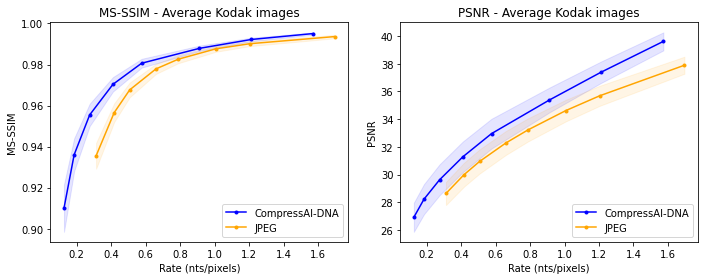

In [42]:
(average_kodim_jpeg_rate, average_kodim_compressai_rate, average_kodim_jpeg_msssim, 
 average_kodim_compressai_msssim,average_kodim_jpeg_psnr,average_kodim_compressai_psnr)=(get_averages(kodim_jpeg_rates, 
                                                                                        kodim_compressai_rates, 
                                                                                        kodim_jpeg_mssim, 
                                                                                        kodim_compressai_mssim, 
                                                                                        kodim_jpeg_psnr, 
                                                                                        kodim_compressai_psnr))

                                                                           
plot_jpeg_dnaCompressAI((average_kodim_compressai_rate, average_kodim_compressai_msssim, average_kodim_compressai_psnr), 
                        (average_kodim_jpeg_rate, average_kodim_jpeg_msssim, average_kodim_jpeg_psnr), f"Average Kodak images",
                       get_all_ci_s(kodim_jpeg_mssim, kodim_compressai_mssim, kodim_jpeg_psnr, kodim_compressai_psnr))


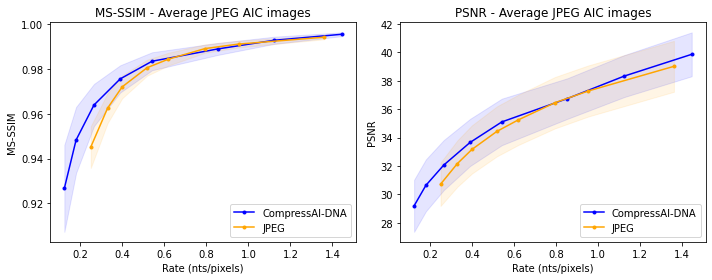

In [43]:
(average_dna_jpeg_rate, average_dna_compressai_rate, average_dna_jpeg_msssim, 
 average_dna_compressai_msssim,average_dna_jpeg_psnr,average_dna_compressai_psnr)=(get_averages(dna_jpeg_rates, 
                                                                                        dna_compressai_rates, 
                                                                                        dna_jpeg_mssim, 
                                                                                        dna_compressai_mssim, 
                                                                                        dna_jpeg_psnr, 
                                                                                        dna_compressai_psnr))

                                                                           
plot_jpeg_dnaCompressAI((average_dna_compressai_rate, average_dna_compressai_msssim, average_dna_compressai_psnr), 
                        (average_dna_jpeg_rate, average_dna_jpeg_msssim, average_dna_jpeg_psnr), f"Average JPEG AIC images",
                       get_all_ci_s(dna_jpeg_mssim, dna_compressai_mssim, dna_jpeg_psnr, dna_compressai_psnr))


## Functions to plot a single image

Note that there is no confidence interval to plot.

In [44]:
def plot_single_dna_im(img_nb):
    """
    Plots the quality metrics (MS-SSIM and PSNR) for the dna dataset image "img_nb"

    Parameters
    ----------
    img_nb : int
        the number of the image (1-10)
    """
    
    index = img_nb-1
    plot_jpeg_dnaCompressAI((dna_compressai_rates[index], dna_compressai_mssim[index], dna_compressai_psnr[index]), 
                        (dna_jpeg_rates[index], dna_jpeg_mssim[index], dna_jpeg_psnr[index]), 
                            f"JPEG AIC image {img_nb:02d}")

In [45]:
def plot_single_kodim(img_nb):
    """
    Plots the quality metrics (MS-SSIM and PSNR) for the kodak dataset image "img_nb"

    Parameters
    ----------
    img_nb : int
        the number of the image (1-24)
    """
    index = img_nb-1
    plot_jpeg_dnaCompressAI((kodim_compressai_rates[index], kodim_compressai_mssim[index], kodim_compressai_psnr[index]), 
                        (kodim_jpeg_rates[index], kodim_jpeg_mssim[index], kodim_jpeg_psnr[index]), 
                            f"kodim{img_nb:02d}")

In [46]:
def plot_single_img(img_type, img_nb):
    """
    Plots the quality metrics (MS-SSIM and PSNR) for the image "img_nb" of the given dataset

    Parameters
    ----------
    img_nb : int
        the number of the image (1-24)
    img_type : string
        "kodim" or "dna_im_" depending on the dataset
    """
    
    if img_type == "kodim":
        plot_single_kodim(img_nb)
    else:
        plot_single_dna_im(img_nb)

To plot the MS-SSIM and PSNR rates for all quality levels/alpha values of an image, run `plot_single_img` with "kodim" or "dna_im_" as img_type and the image number you want to encode (1-24 for the kodak dataset, 1-10 for the DNA dataset).

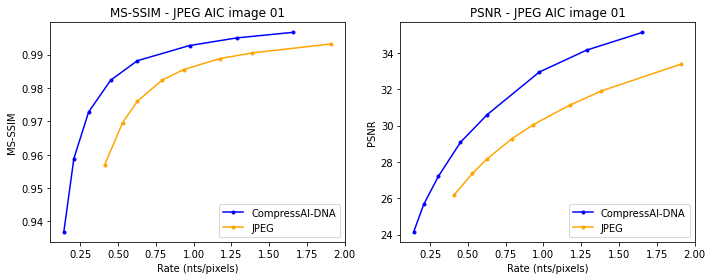

In [47]:
plot_single_img("dna_im_", 1)

## Function to plot images and crops

In [48]:
def plot_crop_images(jpeg_xhat, compressai_xhat, img_nb, img_type, jpeg_rate, compressai_rate, crop=None):
    """
    Plots a crop of the reconstructed JPEG DNA BC and modified CompressAI autoencoder images, as well as the 
    original image. If the crop is None, plots the whole image.
    
    Parameters
    ----------
    jpeg_xhat : tensor
        image tensor reconstructed from original image using the JPEG DNA BC
    compressai_xhat : tensor
        image tensor reconstructed from original image using the modified CompressAI autoencoder
    img_nb : int
        the number of the image (1-10 for the DNA dataset, 1-24 for the kodak dataset)
    img_type : string
        "kodim" or "dna_im_" depending on the dataset
    crop : tuple, optional
        The region of the image to plot or None is the entire image should be plotted
    """
    
    img_jpeg = transforms.ToPILImage()(jpeg_xhat.squeeze().cpu())
    img_compressai = transforms.ToPILImage()(compressai_xhat.squeeze().cpu())
        
    original, ignored = get_image(f"./assets/{img_type}{img_nb:02d}.png")
    original = transforms.ToPILImage()(original.squeeze().cpu())
    
    if crop == None:
        (x, y) = original.size
        crop = (0, 0, x, y)

    %matplotlib inline
    fix, axes = plt.subplots(1, 3, figsize=(22, 14))
    for ax in axes:
        ax.axis('off')

    axes[0].imshow(img_jpeg.crop(crop))
    axes[0].title.set_text(f'JPEG DNA BC with rate {jpeg_rate:.4f}')

    axes[1].imshow(img_compressai.crop(crop))
    axes[1].title.set_text(f'DNA-CompressAI with rate {compressai_rate:.4f}')

    axes[2].imshow(original.crop(crop))
    axes[2].title.set_text('Original')

    plt.show()

In [49]:
def plot_image(img_type, img_nb, quality, alpha_val, crop=None):
    """
    Plots a crop of the reconstructed JPEG DNA BC and modified CompressAI autoencoder images, as well as the 
    original image. If the crop is None, plots the whole image. Note that quality and alpha value are used to plot the
    image at the correct rate. The two parameters do not need to be equal, but the rate of the image should be as 
    close as possible.
    
    Parameters
    ----------
    img_type : string
        "kodim" or "dna_im_" depending on the dataset
    img_nb : int
        the number of the image (1-10 for the DNA dataset, 1-24 for the kodak dataset)
    quality : int
        the quality level (1-8) at which the image to be plotted was encoded
    alpha_val : int
        the index (1-8) of the alpha value with which the image to be plotted was encoded
    crop : tuple, optional
        The region of the image to plot or None is the entire image should be plotted
    """
    idx = img_nb-1
    if img_type == "kodim":
        plot_crop_images(kodim_jpeg_xhats[idx][alpha_val-1], kodim_compressai_xhats[idx][quality-1], img_nb, "kodim", 
                         kodim_jpeg_rates[idx][alpha_val-1], kodim_compressai_rates[idx][quality-1], crop=crop)
    else:
        plot_crop_images(dna_jpeg_xhats[idx][alpha_val-1], dna_compressai_xhats[idx][quality-1], img_nb, "dna_im_", 
                         dna_jpeg_rates[idx][alpha_val-1], dna_compressai_rates[idx][quality-1], crop=crop)
        

To plot the an image or a crop an image, run `plot_crop_images` with "kodim" or "dna_im_" as `img_type` and the image number you want to encode (1-24 for the kodak dataset, 1-10 for the DNA dataset). To plot the whole image, do not include a crop. To choose `quality` and `alpha_val`, use `plot_single_img` to find appropriate values (in which the corresponding rate is close, as is makes most sense to compares images encoded at similar rates).

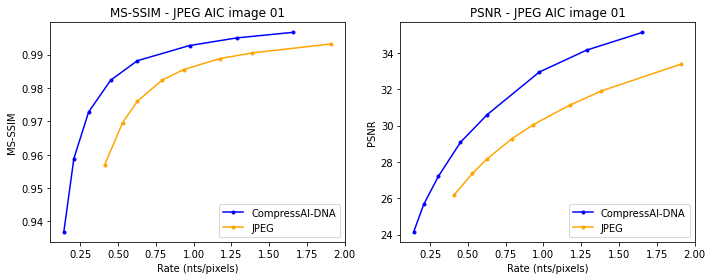

In [50]:
plot_single_img("dna_im_", 1)

## 2. Comparison to classical codecs

Let's perform some comparison against JPEG and WebP as they are included in the Pillow library.

In [51]:
def pillow_encode(img, fmt='jpeg', quality=10):
    tmp = io.BytesIO()
    img.save(tmp, format=fmt, quality=quality)
    tmp.seek(0)
    filesize = tmp.getbuffer().nbytes
    bpp = filesize * float(8) / (img.size[0] * img.size[1])
    rec = Image.open(tmp)
    return rec, bpp

In [52]:
from functools import partial

In [53]:
def find_closest_bpp(target, img, fmt='jpeg'):
    lower = 0
    upper = 100
    prev_mid = upper
    for i in range(10):
        mid = (upper - lower) / 2 + lower
        if int(mid) == int(prev_mid):
            break
        rec, bpp = pillow_encode(img, fmt=fmt, quality=int(mid))
        if bpp > target:
            upper = mid - 1
        else:
            lower = mid
    return rec, bpp

def find_closest_psnr(target, img, fmt='jpeg'):
    lower = 0
    upper = 100
    prev_mid = upper
    
    def _psnr(a, b):
        a = np.asarray(a).astype(np.float32)
        b = np.asarray(b).astype(np.float32)
        mse = np.mean(np.square(a - b))
        return 20*math.log10(255.) -10. * math.log10(mse)
    
    for i in range(10):
        mid = (upper - lower) / 2 + lower
        if int(mid) == int(prev_mid):
            break
        prev_mid = mid
        rec, bpp = pillow_encode(img, fmt=fmt, quality=int(mid))
        psnr_val = _psnr(rec, img)
        if psnr_val > target:
            upper = mid - 1
        else:
            lower = mid
    return rec, bpp, psnr_val

def find_closest_msssim(target, img, fmt='jpeg'):
    lower = 0
    upper = 100
    prev_mid = upper
    
    def _mssim(a, b):
        a = torch.from_numpy(np.asarray(a).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)
        b = torch.from_numpy(np.asarray(b).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)
        return ms_ssim(a, b, data_range=255.).item()

    for i in range(10):
        mid = (upper - lower) / 2 + lower
        if int(mid) == int(prev_mid):
            break
        prev_mid = mid
        rec, bpp = pillow_encode(img, fmt=fmt, quality=int(mid))
        msssim_val = _mssim(rec, img)
        if msssim_val > target:
            upper = mid - 1
        else:
            lower = mid
    return rec, bpp, msssim_val

### 2.1 Quality comparison at similar bit-rate

In [54]:
target_bpp = compute_bpp(out_net)
rec_jpeg, bpp_jpeg = find_closest_bpp(target_bpp, img)
rec_webp, bpp_webp = find_closest_bpp(target_bpp, img, fmt='webp')

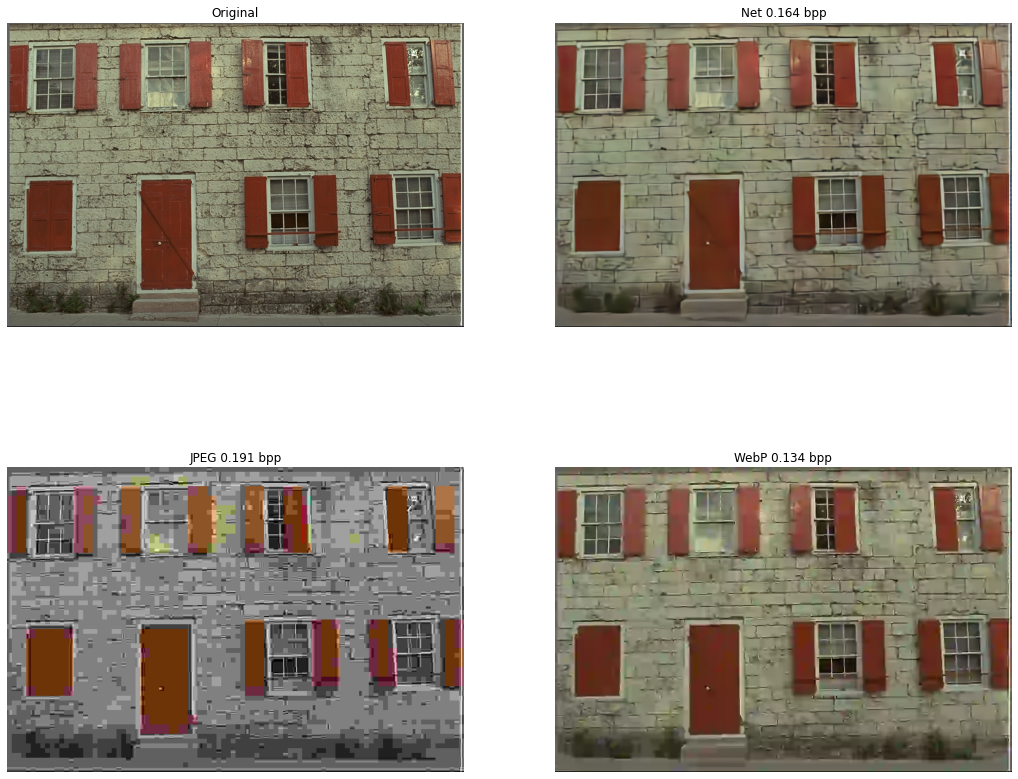

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
for ax in axes.ravel():
    ax.axis('off')

fig.title = 'yolo'
axes[0][0].imshow(img)
axes[0][0].title.set_text('Original')
axes[0][1].imshow(rec_net)
axes[0][1].title.set_text(f'Net {target_bpp:.3f} bpp')
axes[1][0].imshow(rec_jpeg)
axes[1][0].title.set_text(f'JPEG {bpp_jpeg:.3f} bpp')
axes[1][1].imshow(rec_webp)
axes[1][1].title.set_text(f'WebP {bpp_webp:.3f} bpp')

plt.show()

### 2.2 Bit-rate comparison at similar PSNR

In [56]:
target_psnr = compute_psnr(x, out_net["x_hat"])
rec_jpeg, bpp_jpeg, psnr_jpeg = find_closest_psnr(target_psnr, img)
rec_webp, bpp_webp, psnr_webp = find_closest_psnr(target_psnr, img, fmt='webp')

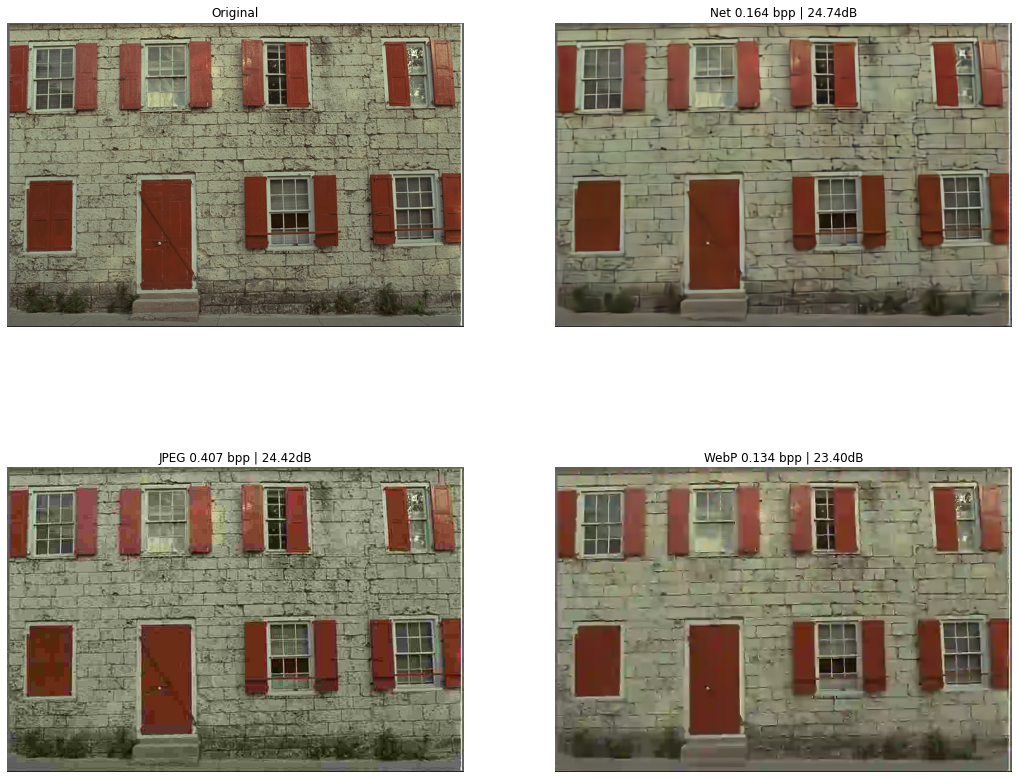

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
for ax in axes.ravel():
    ax.axis('off')
    
axes[0][0].imshow(img)
axes[0][0].title.set_text('Original')
axes[0][1].imshow(rec_net)
axes[0][1].title.set_text(f'Net {target_bpp:.3f} bpp | {target_psnr:.2f}dB')
axes[1][0].imshow(rec_jpeg)
axes[1][0].title.set_text(f'JPEG {bpp_jpeg:.3f} bpp | {psnr_jpeg:.2f}dB')
axes[1][1].imshow(rec_webp)
axes[1][1].title.set_text(f'WebP {bpp_webp:.3f} bpp | {psnr_webp:.2f}dB')

plt.show()

### 2.3) Bit-rate comparison at similar MS-SSIM

In [58]:
target_msssim = compute_msssim(x, out_net["x_hat"])
rec_jpeg, bpp_jpeg, msssim_jpeg = find_closest_msssim(target_msssim, img)
rec_webp, bpp_webp, msssim_webp = find_closest_msssim(target_msssim, img, fmt='webp')

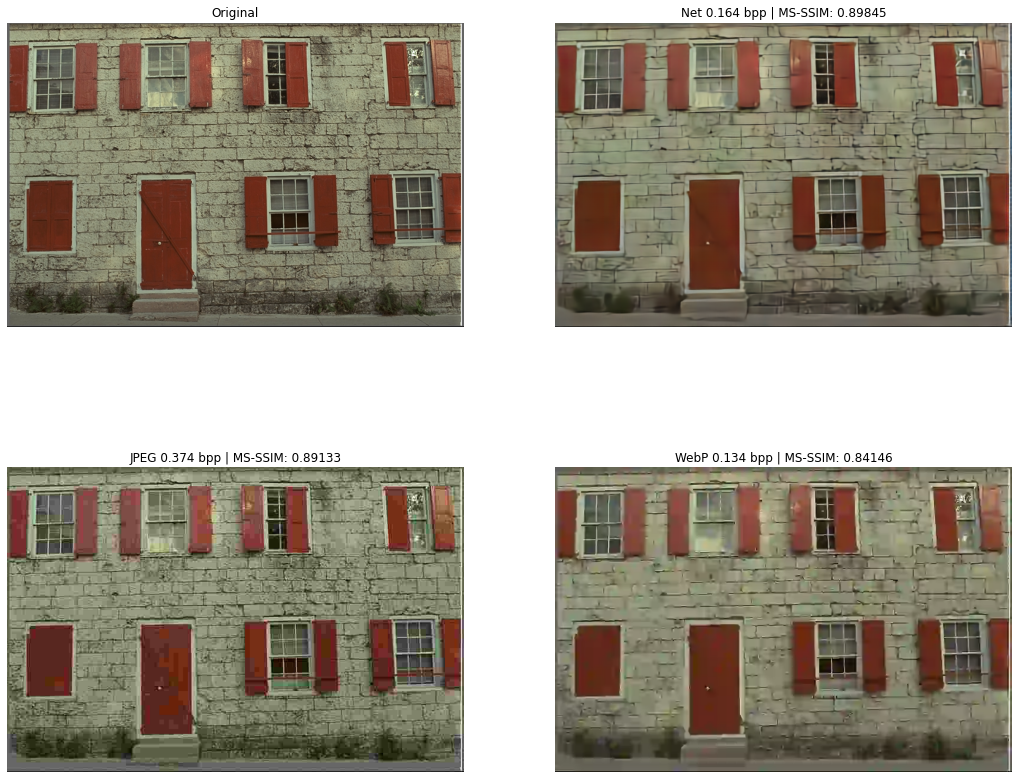

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
for ax in axes.ravel():
    ax.axis('off')
    
axes[0][0].imshow(img)
axes[0][0].title.set_text('Original')
axes[0][1].imshow(rec_net)
axes[0][1].title.set_text(f'Net {target_bpp:.3f} bpp | MS-SSIM: {target_msssim:.5f}')
axes[1][0].imshow(rec_jpeg)
axes[1][0].title.set_text(f'JPEG {bpp_jpeg:.3f} bpp | MS-SSIM: {msssim_jpeg:.5f}')
axes[1][1].imshow(rec_webp)
axes[1][1].title.set_text(f'WebP {bpp_webp:.3f} bpp | MS-SSIM: {msssim_webp:.5f}')

plt.show()

## 3. Latent visualization

### Per-latent bit-rate results

In [60]:
def detailed_bpp(out):
    size = out['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    for name, values in out_net['likelihoods'].items():
        bpp_val = torch.log(values).sum() / (-math.log(2) * num_pixels)
        print(f'- "{name}" latent bit-rate: {bpp_val:.3f} bpp')
               
detailed_bpp(out_net)

- "y" latent bit-rate: 0.164 bpp


In [61]:
with torch.no_grad():
    y = net.g_a(x)
    y_hat, y_likelihoods, ignored = net.entropy_bottleneck(y)
    print(y.size(), y_likelihoods.size())

torch.Size([1, 192, 32, 48]) torch.Size([1, 192, 32, 48])


## Per channel estimated bit-rate

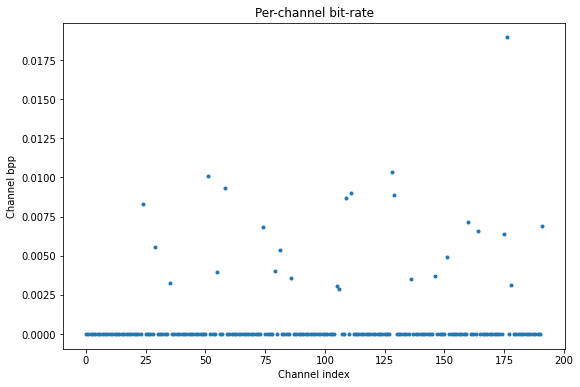

In [62]:
%matplotlib inline
num_pixels = x.size(2) * x.size(3)

channel_bpps = [torch.log(y_likelihoods[0, c]).sum().item() / (-math.log(2) * num_pixels)
                for c in range(y.size(1))]

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(channel_bpps, '.')
ax.title.set_text('Per-channel bit-rate')
ax.set_xlabel('Channel index')
ax.set_ylabel('Channel bpp')
plt.show()

### Order channels by bit-rates

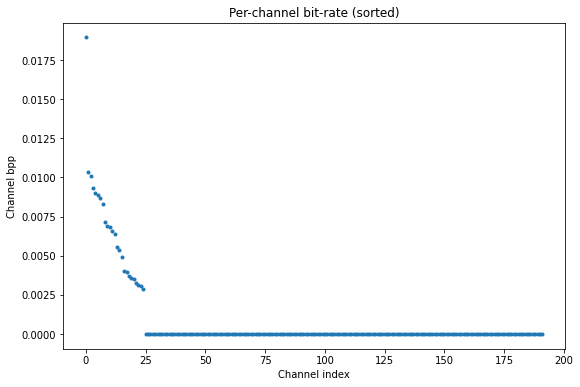

In [63]:
%matplotlib inline
num_pixels = x.size(2) * x.size(3)

ordered_idxs = torch.argsort(torch.Tensor(channel_bpps), descending=True)
ordered_channel_bpps = torch.Tensor(channel_bpps)[ordered_idxs]

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(ordered_channel_bpps, '.')
ax.title.set_text('Per-channel bit-rate (sorted)')
ax.set_xlabel('Channel index')
ax.set_ylabel('Channel bpp')
plt.show()

### Interactive per-channel visualization

In [64]:
from IPython.display import display, clear_output

In [65]:
%%capture
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(12, 9))
for ax in axes:
    ax.axis('off')

out = widgets.Output()
def show_channel(c):
    channel = y[0, ordered_idxs[c]].cpu()
    axes[0].imshow(channel)
    axes[0].title.set_text(f'Y | min: {channel.min():.2f} | max: {channel.max():.2f}')
    
    channel = y_hat[0, ordered_idxs[c]].cpu()
    axes[1].imshow(channel)
    axes[1].title.set_text(f'Yhat | min: {channel.min():.2f} | max: {channel.max():.2f}')
    with out:
        clear_output(wait=True)
        display(fig)

In [66]:
slider = widgets.IntSlider(min=0, max=y.size(1)-1, step=1,continuous_update=False, description='Channel idx')
slider.observe(lambda ev: show_channel(slider.value))
show_channel(0)
display(widgets.VBox([out, slider]))

## Quantized vs continuous latent

In [67]:
with torch.no_grad():
    x_hat_y = net.g_s(y).clamp_(0, 1)
    x_hat_y_hat = net.g_s(y_hat).clamp_(0, 1)

In [68]:
print('Decoded continuous latent:')
print(f'PSNR: {compute_psnr(x, x_hat_y):.2f}dB')
print(f'MS-SSIM: {compute_msssim(x, x_hat_y):.4f}')
print()
print('Decoded quantized latent:')
print(f'PSNR: {compute_psnr(x, x_hat_y_hat):.2f}dB')
print(f'MS-SSIM: {compute_msssim(x, x_hat_y_hat):.4f}')

Decoded continuous latent:
PSNR: 25.39dB
MS-SSIM: 0.9133

Decoded quantized latent:
PSNR: 24.74dB
MS-SSIM: 0.8984


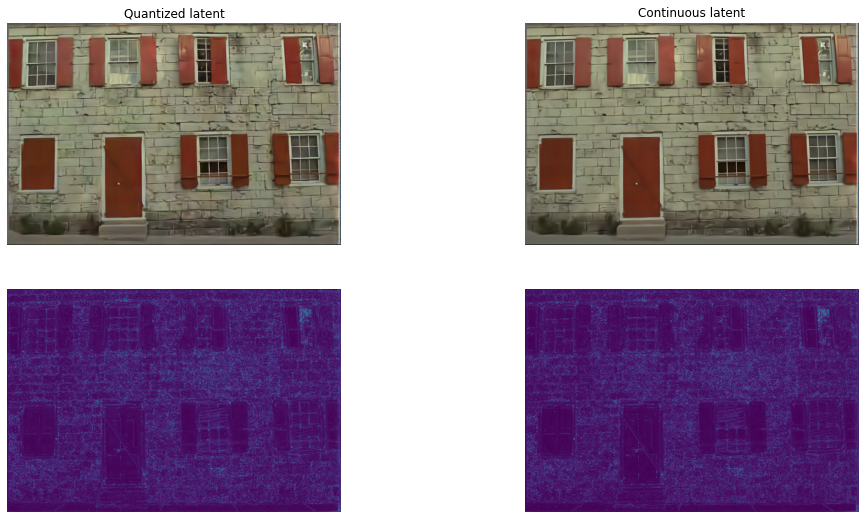

In [69]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(17, 9))
for ax in axes.ravel():
    ax.axis('off')
    
    axes[0][0].imshow(transforms.ToPILImage()(x_hat_y_hat.squeeze().cpu()))
    axes[0][0].title.set_text('Quantized latent')
    
    axes[1][0].imshow(torch.mean((x - x_hat_y_hat).abs(), axis=1).squeeze().cpu())
    
    axes[0][1].imshow(transforms.ToPILImage()(x_hat_y.squeeze()))
    axes[0][1].title.set_text('Continuous latent')
    
    axes[1][1].imshow(torch.mean((x - x_hat_y).abs(), axis=1).squeeze().cpu())

plt.show()